In [2]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [3]:
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

In [4]:
pointCount = 4
points = generateData.samplePoints(pointCount=pointCount).detach().numpy()
adjacent_points = generateData.samplePoints(pointCount=pointCount).detach().numpy()

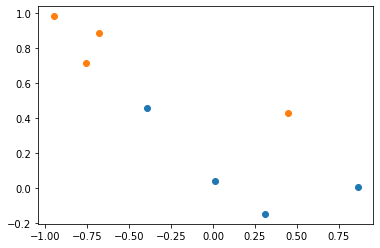

In [5]:
plt.scatter( points[:, 0], points[:, 1] )
plt.scatter( adjacent_points[:, 0], adjacent_points[:, 1] )

In [40]:
points

array([[ 0.01230858,  0.0410976 ],
       [ 0.3082738 , -0.14802416],
       [ 0.8651791 ,  0.00793682],
       [-0.39617836,  0.45495903]], dtype=float32)

In [41]:
adjacent_points

array([[-0.757561  ,  0.714921  ],
       [ 0.4494885 ,  0.42756736],
       [-0.94982153,  0.9824639 ],
       [-0.6808385 ,  0.88613325]], dtype=float32)

In [70]:
# Build matrix of distances between particles
from scipy.spatial.distance import cdist
distMatrix = cdist(points, adjacent_points)
distMatrix

array([[1.02310174, 0.58351106, 1.34605529, 1.09294929],
       [1.37137821, 0.59266111, 1.69139205, 1.43102227],
       [1.77005995, 0.59066784, 2.06008019, 1.77803249],
       [0.44517149, 0.84611036, 0.76471049, 0.5166649 ]])

# Example with real Neural network

In [122]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

gamma_adjacent = 1e-3
pointCount = 20
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 4000]

In [123]:
xData = generateData.samplePoints(pointCount=pointCount)
xAdjacentData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)

yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        yData = network.computeValueFunction(xData)
        yAdjacentData = network.computeValueFunction(xAdjacentData)
        
        # compute loss and backpropagate
        lossData = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        # we compute the matrix based on the x's, en evaluate the loss with the y's
        distMatrix = 1 / cdist(xData.detach().numpy(), xAdjacentData.detach().numpy())
        lossAdjacent = ( ( yData - yAdjacentData.T )**2 * torch.tensor(distMatrix).float() ).sum()

        loss = lossData + gamma_adjacent * lossAdjacent

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

0 / 7000 (0 / 1000), lr:1.0e-02, loss:6.68e-01
100 / 7000 (100 / 1000), lr:1.0e-02, loss:1.26e-02
200 / 7000 (200 / 1000), lr:1.0e-02, loss:1.24e-02
300 / 7000 (300 / 1000), lr:1.0e-02, loss:1.19e-02
400 / 7000 (400 / 1000), lr:1.0e-02, loss:1.12e-02
500 / 7000 (500 / 1000), lr:1.0e-02, loss:1.05e-02
600 / 7000 (600 / 1000), lr:1.0e-02, loss:1.01e-02
700 / 7000 (700 / 1000), lr:1.0e-02, loss:9.55e-03
800 / 7000 (800 / 1000), lr:1.0e-02, loss:7.54e-03
900 / 7000 (900 / 1000), lr:1.0e-02, loss:6.13e-03
1000 / 7000 (0 / 2000), lr:1.0e-03, loss:5.97e-03
1100 / 7000 (100 / 2000), lr:1.0e-03, loss:5.92e-03
1200 / 7000 (200 / 2000), lr:1.0e-03, loss:5.88e-03
1300 / 7000 (300 / 2000), lr:1.0e-03, loss:5.85e-03
1400 / 7000 (400 / 2000), lr:1.0e-03, loss:5.82e-03
1500 / 7000 (500 / 2000), lr:1.0e-03, loss:5.78e-03
1600 / 7000 (600 / 2000), lr:1.0e-03, loss:5.75e-03
1700 / 7000 (700 / 2000), lr:1.0e-03, loss:5.71e-03
1800 / 7000 (800 / 2000), lr:1.0e-03, loss:5.67e-03
1900 / 7000 (900 / 2000), lr

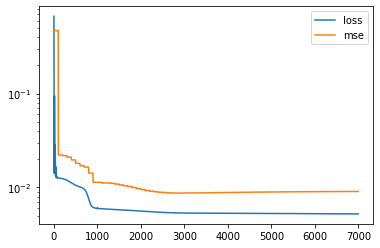

In [124]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

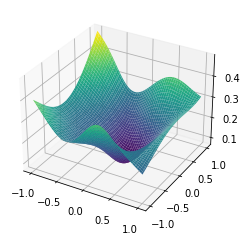

In [125]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Reference

In [294]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)

gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':1}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

In [295]:
lrs = [1e-3, 1e-4]
iterations = [500, 1000]

resu = lqr.train(interiorPointCount=100, dataPointCount=100, lrs=lrs, iterations=iterations, useTestData=False, verbose=True)

xInt:  torch.Size([100, 2])
xData:  torch.Size([100, 2])
0 / 1500 (0 / 500), lr:1.0e-03, loss:8.47e-01 (data: 6.84e-01, grad: 1.63e-01, res: 0.00e+00, mat: 0.00e+00)
100 / 1500 (100 / 500), lr:1.0e-03, loss:1.79e-01 (data: 1.88e-02, grad: 1.60e-01, res: 0.00e+00, mat: 0.00e+00)
200 / 1500 (200 / 500), lr:1.0e-03, loss:1.75e-01 (data: 1.78e-02, grad: 1.58e-01, res: 0.00e+00, mat: 0.00e+00)
300 / 1500 (300 / 500), lr:1.0e-03, loss:1.71e-01 (data: 1.73e-02, grad: 1.54e-01, res: 0.00e+00, mat: 0.00e+00)
400 / 1500 (400 / 500), lr:1.0e-03, loss:1.66e-01 (data: 1.66e-02, grad: 1.49e-01, res: 0.00e+00, mat: 0.00e+00)
500 / 1500 (0 / 1000), lr:1.0e-04, loss:1.58e-01 (data: 1.58e-02, grad: 1.43e-01, res: 0.00e+00, mat: 0.00e+00)
600 / 1500 (100 / 1000), lr:1.0e-04, loss:1.56e-01 (data: 1.57e-02, grad: 1.41e-01, res: 0.00e+00, mat: 0.00e+00)
700 / 1500 (200 / 1000), lr:1.0e-04, loss:1.55e-01 (data: 1.55e-02, grad: 1.39e-01, res: 0.00e+00, mat: 0.00e+00)
800 / 1500 (300 / 1000), lr:1.0e-04, loss:

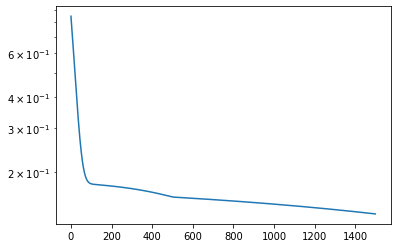

In [296]:
plt.plot( resu['loss'] )
plt.yscale('log')

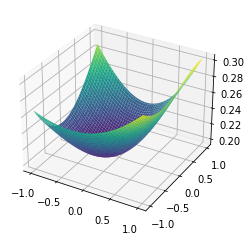

In [297]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = lqr.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');